# Import moduls

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# moduls for img_preprocessing()
import cv2, sys
from PIL import Image

# moduls for KNN_color()
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.neighbors import KNeighborsClassifier

# modul for significant_color_knn()
from collections import Counter

# Functions

In [3]:
def img_preprocessing(img):
    img = img.convert("RGBA")
    img = img.resize((128, 128))
    datas = img.getdata()
    
    newData = []
    cutoff = 200
    
    # cutoff 
    for item in datas:
        if item[0] >= cutoff and item[1] >= cutoff and item[2] >= cutoff:
            newData.append((255, 255, 255, 0)) # if RGB value is over cutoff, consider as background (white)
        else:
            newData.append(item)  # don't change others

    img.putdata(newData)
    plt.imshow(img)
    
    img_pixel = pd.DataFrame(np.array(newData))
    drop_idx = img_pixel[img_pixel[3] == 0].index  # if pixel is transparent, dorp
    img_pixel = img_pixel.drop(drop_idx)
    pixels = img_pixel.drop(columns=[3], axis=1)
    pixels.columns = ['R', 'G', 'B']
    pixels = pixels.reset_index(drop=True)
    
    return pixels

In [4]:
def KNN_color(rgb_data):
    X = rgb_data[['R', 'G', 'B']]
    y = rgb_data['index']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,train_size = 0.7,test_size = 0.3,random_state = 0)
    
    knn = KNeighborsClassifier(n_neighbors=8)  # set KNN model
    knn.fit(X_train, y_train)
    
    print('train set score:', knn.score(X_train, y_train))
    print('test set score:', knn.score(X_test, y_test))
    print()
    
    n_test = len(y_test)
    y_predict = knn.predict(X_test)

    print('test data length:', n_test)
    print('Number of data that matched the prediction:', sum(y_test == y_predict))
    print('match rate:',round(sum(y_test == y_predict)/n_test*100,2),'%')
    
    return knn

In [5]:
def draw_pie(color_counts, det_col, colors, name):
    plt.figure(figsize = (8, 6))
    plt.pie(color_counts.values(), labels = det_col, colors=det_col)
    plt.savefig(f'{name}_KNN_pie.png')
    plt.show()

In [6]:
def draw_scatter(predicted, cols_for_scatter, name):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.scatter(predicted['R'], predicted['G'], predicted['B'], c = cols_for_scatter);
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.set_title('image color classification using KNN', y=1.02)

    plt.tight_layout()
    plt.savefig(f'{name}_KNN_color_classify.png')
    plt.show()

In [7]:
def significant_color_knn(pixels, name = 'photo', pie_yn = 1, scatter_yn = 1):
    colors = ['aqua','black', 'blue', 'fuchsia', 'green', 'lime', 'maroon', 'navy', 'red', 'white', 'yellow']
    
    pred_color = knn.predict(pixels)  # identify color using learned model
    color_counts = Counter(knn.predict(pixels))  # count label
    detected = [i for i in color_counts.keys()]  # key of color_counts
        
    # if pie_yn == 0, do not draw pie chart.
    # default is 1, which draws pie chart
    if (pie_yn):  # pie chart
        det_col = []
        for i in range(len(detected)):  # function for identifiying color name of the key
            det_col.append(colors[detected[i]])
        draw_pie(color_counts, det_col, colors, name)
        
    # making into single dataframe of the rgb values and the result
    predicted = pd.DataFrame(pred_color)
    predicted.columns = ['index']
    predicted = pixels.join(predicted)
    
    # if scatter_yn == 0, do not draw scatter plot
    # default is 1, which draws scatter plot
    if (scatter_yn):
        pred_col = predicted['index'].to_list()
        
        cols_for_scatter = []
        for i in range(len(pred_col)):
            cols_for_scatter.append(colors[pred_col[i]])
            
        draw_scatter(predicted, cols_for_scatter, name)
    
    # index of most significant color
    for k, v in color_counts.items():
        if v == max(color_counts.values()):
            max_idx = k
            
    return html[html['index'] == max_idx]['name']

# Run

In [8]:
img = Image.open('./sampleImage/rainbow_knit.jpg')  # image to identify color
rgb_data = pd.read_csv('./colorChart/augmented_color_chart_11.csv')  # data to learn (augmented)
html = pd.read_csv('./colorChart/colorChart_11.csv')  # data to identify color (non-augmented data)

CPU times: total: 62.5 ms
Wall time: 52 ms


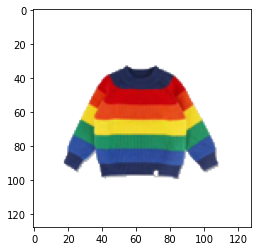

In [9]:
%%time

pixels = img_preprocessing(img = img)

In [10]:
%%time

knn = KNN_color(rgb_data = rgb_data)

train set score: 0.9881925522252498
test set score: 0.9872881355932204

test data length: 3304
Number of data that matched the prediction: 3262
match rate: 98.73 %
CPU times: total: 359 ms
Wall time: 353 ms


In [13]:
%%time

# second parameter 'name' is the name of the chart to save.
# recomend to use what type or object of the image you are identifying
# default = 'photo'
identified_color = significant_color_knn(pixels = pixels, name = 'rainbow', pie_yn = 0, scatter_yn = 0)

CPU times: total: 203 ms
Wall time: 204 ms


In [14]:
print(identified_color)

7    navy
Name: name, dtype: object
